In [1]:
import sys
# import sklearn
import numpy as np
import pandas as pd
from time import time
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import linear_model
from copy import deepcopy
pd.set_option('display.max_columns', 50)
f"Python: {sys.version}"

'Python: 3.7.4 (default, Aug  9 2019, 18:34:13) [MSC v.1915 64 bit (AMD64)]'

### Setup

In [2]:
trainData = pd.read_csv("tcdml1920-rec-click-pred--training.csv", index_col='recommendation_set_id', low_memory=False)
testData = pd.read_csv("tcdml1920-rec-click-pred--test.csv", index_col='recommendation_set_id', low_memory=False)

#drops 1647 rows with nothing
testData.dropna(how="all", inplace=True)

In [3]:
# Row Duplication check TrainData
duplicateRowsTrain = trainData[trainData.duplicated()]
duplicateRowsTrain.shape

(285, 45)

In [4]:
# Row Duplication check TestData
duplicateRowsTest = testData[testData.duplicated()]
duplicateRowsTest.shape

(0, 45)

In [5]:
trainData = trainData.drop_duplicates()
trainData.shape

(385402, 45)

In [6]:
trainData.replace(["\\N", "nA", "Not provided", "unknown", "*unknown*"], np.nan, inplace=True)
testData.replace(["\\N", "nA", "Not provided",  "unknown", "*unknown*"], np.nan, inplace=True)

In [7]:
JabRef_trainData = deepcopy(trainData[trainData.organization_id == 1])
JabRef_testData  = deepcopy(testData[testData.organization_id == 1])
MyVolts_trainData = deepcopy(trainData[trainData.organization_id == 4])
MyVolts_testData  = deepcopy(testData[testData.organization_id == 4])
Blog_trainData = deepcopy(trainData[trainData.organization_id == 8])
Blog_testData  = deepcopy(testData[testData.organization_id == 8])

In [8]:
trainData.columns

Index(['user_id', 'session_id', 'query_identifier', 'query_word_count',
       'query_char_count', 'query_detected_language', 'query_document_id',
       'document_language_provided', 'year_published', 'number_of_authors',
       'abstract_word_count', 'abstract_char_count',
       'abstract_detected_language', 'first_author_id',
       'num_pubs_by_first_author', 'organization_id', 'application_type',
       'item_type', 'request_received', 'hour_request_received',
       'response_delivered', 'rec_processing_time', 'app_version', 'app_lang',
       'user_os', 'user_os_version', 'user_java_version', 'user_timezone',
       'country_by_ip', 'timezone_by_ip', 'local_time_of_request',
       'local_hour_of_request', 'number_of_recs_in_set',
       'recommendation_algorithm_id_used', 'algorithm_class', 'cbf_parser',
       'search_title', 'search_keywords', 'search_abstract',
       'time_recs_recieved', 'time_recs_displayed', 'time_recs_viewed',
       'clicks', 'ctr', 'set_clicked'],
  

In [55]:
# dataset = [ JabRef_trainData, MyVolts_trainData, Blog_trainData ]
# dataset = [ trainData ]
d = trainData
d[((d["response_delivered"]- d["request_received"]).dt.total_seconds() > 240
  ) & 
  (d["set_clicked"] == 0) &
  ((d["response_delivered"]- d["request_received"]).dt.total_seconds() != np.datetime64('NaT'))].shape
# print(d[((d["response_delivered"]- d["request_received"]).dt.total_seconds() > 1242400) & d["set_clicked"] == 1].shape)

(11, 45)

In [8]:
dataset = [ JabRef_trainData, JabRef_testData, MyVolts_trainData, MyVolts_testData, Blog_trainData, Blog_testData ]

for d in dataset:
    print(d.number)

In [37]:
dataset = [ JabRef_trainData, JabRef_testData, MyVolts_trainData, MyVolts_testData, Blog_trainData, Blog_testData ]
for d in dataset:
    print(np.where(d.isna().all() == True))
#     print(d.columns[d.isna().all() == True])
#     d = d.dropna(axis = 1, how = 'all')
#     print(d.shape)

(array([0, 1], dtype=int64),)
(array([ 0,  1, 20, 21, 25, 26, 32, 39, 40, 41, 42, 43, 44], dtype=int64),)
(array([ 7,  8,  9, 13, 14, 22, 24, 25, 26, 27], dtype=int64),)
(array([ 7,  8,  9, 13, 14, 20, 21, 22, 24, 25, 26, 27, 32, 39, 40, 41, 42,
       43, 44], dtype=int64),)
(array([ 0,  1,  7,  8,  9, 13, 14, 22, 23, 24, 25, 26, 27], dtype=int64),)
(array([ 0,  1,  7,  8,  9, 13, 14, 20, 21, 22, 23, 24, 25, 26, 27, 32, 39,
       40, 41, 42, 43, 44], dtype=int64),)


In [26]:
JabRef_trainData.columns[(JabRef_trainData.isna().all() == True)]

Index(['user_id', 'session_id'], dtype='object')

In [58]:
JabRef_trainData["recommendation_algorithm_id_used"].value_counts(dropna=False)

2      49792
1      31623
21     28068
27     24959
11     22911
13     17260
14     16625
7      15200
12     14885
8      14027
NaN    10657
10      3869
5       2752
3       2729
6       2585
4       2553
9       2303
15      2295
22      1602
23      1551
24      1443
19       324
32        15
31         9
Name: recommendation_algorithm_id_used, dtype: int64

In [22]:
Blog_trainData["number_of_authors"].value_counts(dropna=False)

NameError: name 'Blog_trainData' is not defined

In [16]:
MyVolts_trainData.columns

Index(['user_id', 'session_id', 'query_identifier', 'query_word_count',
       'query_char_count', 'query_detected_language', 'query_document_id',
       'document_language_provided', 'year_published', 'number_of_authors',
       'abstract_word_count', 'abstract_char_count',
       'abstract_detected_language', 'first_author_id',
       'num_pubs_by_first_author', 'organization_id', 'application_type',
       'item_type', 'request_received', 'hour_request_received',
       'response_delivered', 'rec_processing_time', 'app_version', 'app_lang',
       'user_os', 'user_os_version', 'user_java_version', 'user_timezone',
       'country_by_ip', 'timezone_by_ip', 'local_time_of_request',
       'local_hour_of_request', 'number_of_recs_in_set',
       'recommendation_algorithm_id_used', 'algorithm_class', 'cbf_parser',
       'search_title', 'search_keywords', 'search_abstract',
       'time_recs_recieved', 'time_recs_displayed', 'time_recs_viewed',
       'clicks', 'ctr', 'set_clicked'],
  

In [12]:
MyVolts_trainData["user_id"].value_counts(dropna=False)

\N                                  48326
3ce5de6574b74d9e6f6657547091755b     4034
46015d40bb2433595af1410c746e3471     3448
3902677038066845d9c1efc4073ccbad     3153
a0bcf1241d17237ac6d3dea2fea82cc0     2179
                                    ...  
22c3f07657f468dd9b6bbb47d3466289        3
eec250c1ce93e1977f730c44dd8e5e4d        2
475c938cc71dfebb99d8f9aa7b077a78        2
932dcf4e887ebf44043fe1d53b0e697c        2
246f4b9b0b9f66418324b592f591a927        1
Name: user_id, Length: 200, dtype: int64

In [15]:
JabRef_MetaData col = [
    "user_id",
    "session_id",
    "query_char_count",
    
]


MyVolts_MetaData col = [
    "user_id",
    "session_id",
    "query_char_count",
    "query_document_id",
    
]

Blog_MetaData col = [
    "user_id",
    "session_id",
    "query_document_id",
    
    
]

SyntaxError: invalid syntax (<ipython-input-15-788f434987e0>, line 1)

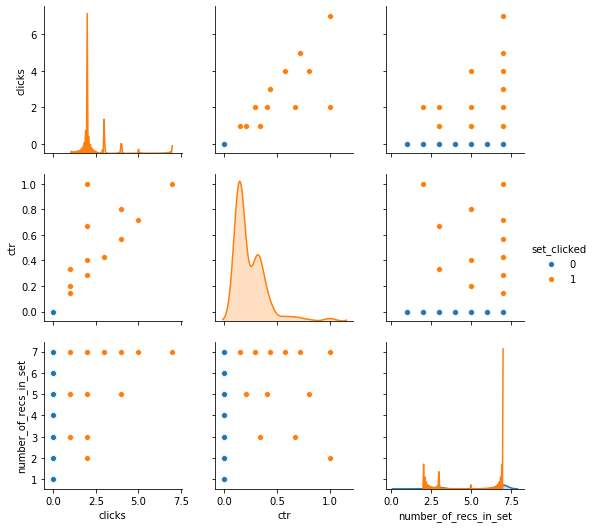

In [48]:
# useful_vars = [f'x{i}' for i in range(30)]
plot = sns.pairplot(data=trainData.sample(10000), vars=['clicks', 'ctr', 'number_of_recs_in_set'], hue ='set_clicked')
# plot.savefig('img/sns_plot.png')

In [18]:
trainData["set_clicked"].value_counts()

0    378639
1      6763
Name: set_clicked, dtype: int64

In [19]:
trainData["ctr"].value_counts()

0.0000    378639
0.1429      3858
0.3333       977
0.2857       944
0.4286       328
0.2000       144
0.5714       132
1.0000        77
0.6667        70
0.7143        48
0.4000        37
0.8571        33
0.1667        30
0.5000        28
0.2500        12
0.6000         8
1.2000         6
1.2857         5
1.1429         4
1.4286         3
0.7500         3
1.3333         3
1.5714         3
2.0000         3
0.8000         2
2.7143         1
2.5000         1
2.5714         1
1.6667         1
1.6000         1
Name: ctr, dtype: int64

In [29]:
# pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 50)
trainData.sample(5)

,user_id,session_id,query_identifier,query_word_count,query_char_count,query_detected_language,query_document_id,document_language_provided,year_published,number_of_authors,abstract_word_count,abstract_char_count,abstract_detected_language,first_author_id,num_pubs_by_first_author,organization_id,application_type,item_type,request_received,hour_request_received,response_delivered,rec_processing_time,app_version,app_lang,user_os,user_os_version,user_java_version,user_timezone,country_by_ip,timezone_by_ip,local_time_of_request,local_hour_of_request,number_of_recs_in_set,recommendation_algorithm_id_used,algorithm_class,cbf_parser,search_title,search_keywords,search_abstract,time_recs_recieved,time_recs_displayed,time_recs_viewed,clicks,ctr,set_clicked
recommendation_set_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
82555,NaN,NaN,Withheld for privacy,10,62,en,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,digital_library,academic_publication,14/01/2019 11:35,11,14/01/2019 11:35,8.529710,4.3.1,en,NaN,NaN,NaN,NaN,FI,200,14/01/2019 12:35,12,7,NaN,NaN,NaN,no,no,no,NaN,NaN,NaN,0,0.0,0
271003,NaN,NaN,Asus Laptop X51L Compatible Power Supply Plug ...,9,53,en,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,e-commerce,NaN,02/07/2019 08:25,8,02/07/2019 08:25,0.048823,NaN,en,NaN,NaN,NaN,NaN,DE,NaN,NaN,NaN,3,12,content_based_filtering,edismax_QP,yes,yes,yes,NaN,NaN,NaN,0,0.0,0
60200,NaN,NaN,Withheld for privacy,12,78,pt,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,digital_library,academic_publication,17/12/2018 19:07,19,17/12/2018 19:07,2.321520,4.3.1,en,NaN,NaN,NaN,NaN,BR,-200,17/12/2018 16:07,16,7,1,content_based_filtering,standard_QP,yes,no,no,NaN,NaN,NaN,0,0.0,0
161059,NaN,NaN,Withheld for privacy,12,85,en,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,digital_library,academic_publication,25/03/2019 16:15,16,25/03/2019 16:15,3.036940,4.3.1,en,NaN,NaN,NaN,NaN,DE,100,25/03/2019 16:15,16,7,2,content_based_filtering,edismax_QP,yes,yes,no,NaN,NaN,NaN,0,0.0,0
63991,NaN,NaN,Withheld for privacy,5,49,en,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,digital_library,academic_publication,21/12/2018 13:40,13,21/12/2018 13:40,0.084040,4.3.1,zh,NaN,NaN,NaN,NaN,CN,800,21/12/2018 20:40,20,7,12,content_based_filtering,edismax_QP,yes,yes,yes,NaN,NaN,NaN,0,0.0,0


In [ ]:
df[df['Sales'] < s]

In [24]:
trainData.iloc[:, :-1].values[0]

array([nan, nan, 'Withheld for privacy', '6', '35', 'en', nan, nan, nan,
       nan, nan, nan, nan, nan, nan, 1, 'digital_library',
       'academic_publication', '03/12/2018 16:28', 16, '03/12/2018 16:28',
       0.681027, '4.3.1', 'en', nan, nan, nan, nan, 'NL',
       'Europe/Amsterdam', nan, nan, 7, '1', 'content_based_filtering',
       'standard_QP', 'yes', 'no', 'no', nan, nan, nan, 0, 0.0],
      dtype=object)

In [22]:
threshold = 0.30

#Dropping rows with missing value rate higher than threshold
trainData.loc[trainData.isnull().mean(axis=1) < threshold].shape

(103996, 45)

In [30]:
trainData.columns

Index(['user_id', 'session_id', 'query_identifier', 'query_word_count',
       'query_char_count', 'query_detected_language', 'query_document_id',
       'document_language_provided', 'year_published', 'number_of_authors',
       'abstract_word_count', 'abstract_char_count',
       'abstract_detected_language', 'first_author_id',
       'num_pubs_by_first_author', 'organization_id', 'application_type',
       'item_type', 'request_received', 'hour_request_received',
       'response_delivered', 'rec_processing_time', 'app_version', 'app_lang',
       'user_os', 'user_os_version', 'user_java_version', 'user_timezone',
       'country_by_ip', 'timezone_by_ip', 'local_time_of_request',
       'local_hour_of_request', 'number_of_recs_in_set',
       'recommendation_algorithm_id_used', 'algorithm_class', 'cbf_parser',
       'search_title', 'search_keywords', 'search_abstract',
       'time_recs_recieved', 'time_recs_displayed', 'time_recs_viewed',
       'clicks', 'ctr', 'set_clicked'],
  

In [42]:
testData["application_type"].value_counts(normalize = False, dropna = False)

digital_library    5174
e-commerce         3027
blog                938
0                     6
Name: application_type, dtype: int64

In [47]:
testData.groupby("search_keywords").mean()

,organization_id,hour_request_received,set_clicked
search_keywords,,,
no,2.747332,12.836220,NaN
yes,2.656268,12.811953,NaN


In [38]:
trainData["application_type"].value_counts(normalize = False, dropna = False)

digital_library    270145
e-commerce         100070
blog                15212
0                     260
Name: application_type, dtype: int64

In [ ]:
# testData[testData['abstract_detected_language'].isnull()]

In [ ]:
testData.isnull().sum().sort_values()

In [ ]:
numeric_columns = [
    "query_word_count",
    "query_char_count",
    "query_document_id",
    "year_published",
    "number_of_authors",
    "abstract_char_count",
    "abstract_word_count",
    "first_author_id",
    "num_pubs_by_first_author",
    "hour_request_received",
    "local_hour_of_request",
    "recommendation_algorithm_id_used",
    "clicks",
]

In [12]:
time_columns = [
    "request_received",
    "response_delivered",
    "local_time_of_request",
    "time_recs_recieved",
    "time_recs_displayed",
    "time_recs_viewed",
]

In [ ]:
for col in numeric_columns:
    trainData[col] = pd.to_numeric(trainData[col], errors="coerce")
    testData[col] = pd.to_numeric(testData[col], errors="coerce")

In [13]:
for col in time_columns:
    trainData[col] = pd.to_datetime(trainData[col], format="%d/%m/%Y %H:%M")
    testData[col] = pd.to_datetime(testData[col], format="%d/%m/%Y %H:%M")

In [ ]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 5)
trainData["query_document_id"].value_counts()

In [ ]:
trainData.columns

In [ ]:
trainData.dtypes

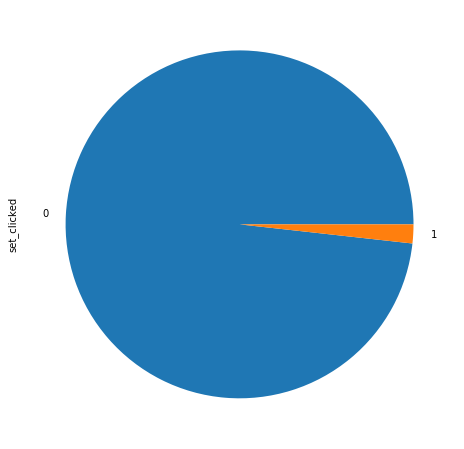

In [50]:
trainData['set_clicked'].value_counts().plot(kind='pie', figsize=(8,8))

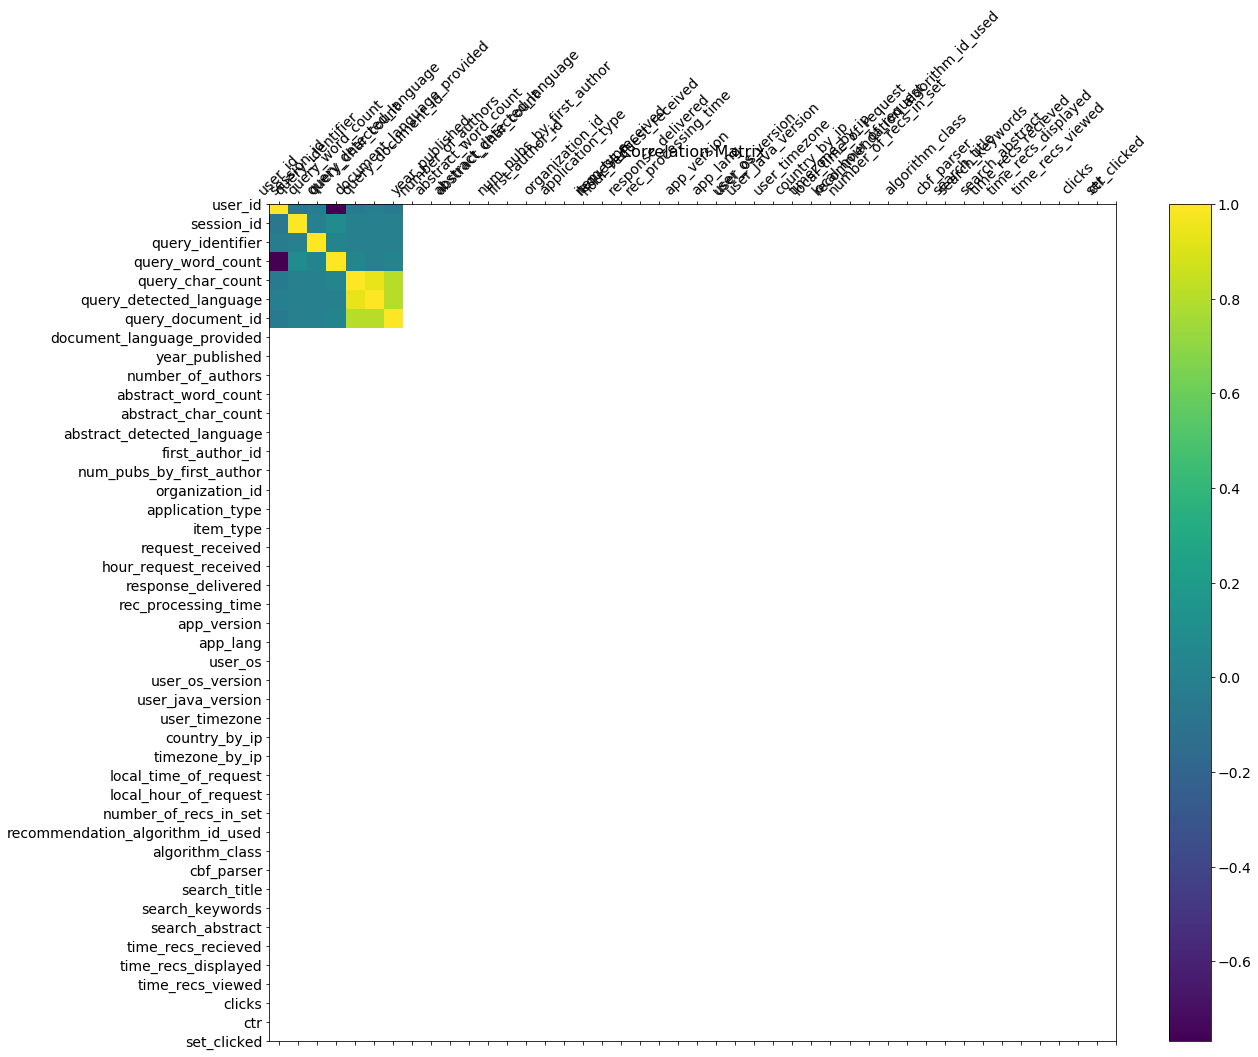

In [49]:
f = plt.figure(figsize=(19, 15))
plt.matshow(trainData.corr(), fignum=f.number)
plt.xticks(range(trainData.shape[1]), trainData.columns, fontsize=14, rotation=45)
plt.yticks(range(trainData.shape[1]), trainData.columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16);